In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os
# This is not super pretty, but I think this is the best way to import stuff from ../../../util?
CODE_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if CODE_ROOT not in sys.path:
    sys.path.insert(1, CODE_ROOT)

from dataset_functions import get_sdss_spectra, get_spectra_reference_point
from plotting_functions import plot_selected_spectra

# Import SDSS Spectra

In [137]:
cat = np.load("../SDSS_support_files/Custom_cat.npz")
snrs_cat = cat["SNR"]
pmfs_cat = cat["PMF"]

pmf_list = []
snr_filter = 0
for i in range(len(snrs_cat)):
    if snrs_cat[i] > snr_filter:
        pmf_list.append(pmfs_cat[i])

print(len(pmf_list))

24145


In [35]:
resid_file = "../SDSS_support_files/residcorr_v5_4_45.dat"

# Note: this function might take a couple of minutes to run as it has to open thousands of data files
snrs, wavelengths_boss_specs, fluxes_boss_specs = get_sdss_spectra(resid_file, pmf_list)

  0%|          | 0/24145 [00:00<?, ?it/s]/vera/u/jerbo/CLIMB-Project/code/Machine_Learning/Transformer_pipeline/dataset_functions.py:213: RuntimeWarning: divide by zero encountered in divide
  F[good_pixel] = (flux[good_pixel] * dla_corr[good_pixel] / ((cont[good_pixel] * resid[good_pixel])))
100%|██████████| 24145/24145 [13:12<00:00, 30.48it/s]


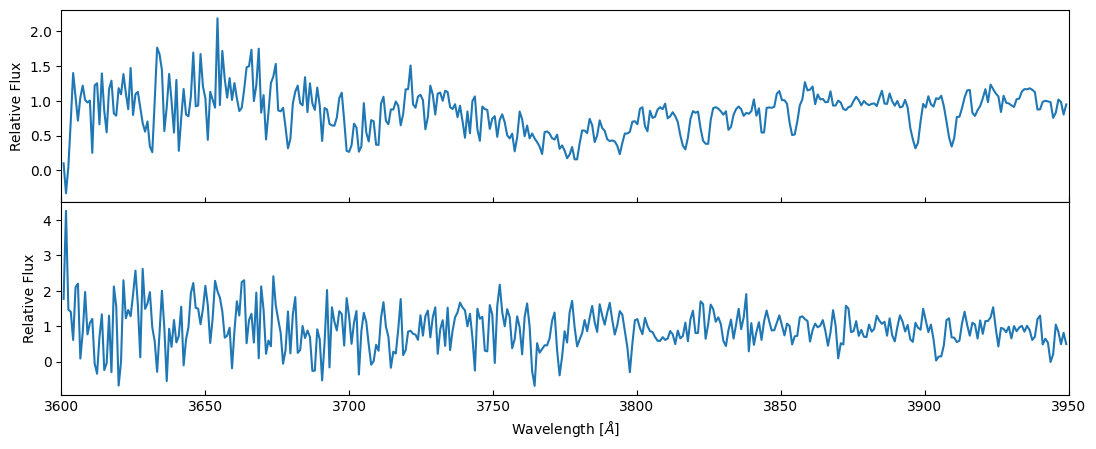

In [139]:
plot_specs, plot_waves = fluxes_boss_specs[:2], wavelengths_boss_specs[:2]
plot_selected_spectra(plot_specs, plot_waves, None, False)

In [37]:
np_specs = []
ivar_snrs = []
for i, spec in enumerate(fluxes_boss_specs):
    if len(spec) == 402:
        np_specs.append(np.append(spec, spec[-1]))
        ivar_snrs.append(np.append(snrs[i], snrs[i][-1]))

specs = np.array(np_specs)
snrs_pp = np.array(ivar_snrs)

print(specs.shape)
print(snrs_pp.shape)

(24145, 403)
(24145, 403)


# Import Simulated Spectra

In [81]:
sim_spectra10, _ = get_spectra_reference_point("L25n256_realistic_noise_mean_6095_sas")
sim_spectra5, _ = get_spectra_reference_point("L25n256_realistic_noise_5_mean_6095_sas")

sim_const100, _ = get_spectra_reference_point("L25n256_snr_sweep_100")

# Plots

In [82]:
# SDSS Spectra
snr_filter_list = [0, 3, 5, 10]
hist_plot_vals = []
for snr_filter in snr_filter_list:
    mask = np.where(snrs_pp.mean(axis=1)>snr_filter)
    hist_plot_vals.append(np.histogram(specs.mean(axis=1)[mask], bins=50, range=(0.6, 1)))

# Simulated Spectra
h_sim_spec10, edges_sim_spec10 = np.histogram(sim_spectra10.mean(axis=1), bins=50, range=(0.6, 1))
h_sim_spec5, edges_sim_spec5 = np.histogram(sim_spectra5.mean(axis=1), bins=50, range=(0.6, 1))

h_sim_const100, edges_sim_const100 = np.histogram(sim_const100.mean(axis=1), bins=50, range=(0.6, 1))

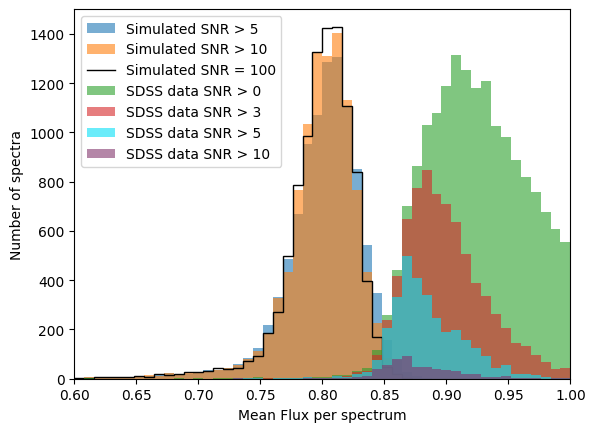

In [ ]:
# Simulated Spectra
plt.stairs(h_sim_spec5, edges_sim_spec5, fill=True, alpha=0.6, label=f"Simulated SNR > 5", color="#1f77b4")
plt.stairs(h_sim_spec10, edges_sim_spec10, fill=True, alpha=0.6, label=f"Simulated SNR > 10", color="#ff7f0e")

plt.stairs(h_sim_const100, edges_sim_const100, fill=False, color="black", label=f"Simulated SNR = 100")

colors = [
    "#2ca02c",
    "#d62728",
    "#07e0f8",
    "#82356c",
]

# SDSS Spectra
for i, (h, edge) in enumerate(hist_plot_vals):
    plt.stairs(h, edge, fill=True, alpha=0.6, label=f"SDSS data SNR > {snr_filter_list[i]}", color=colors[i])

plt.xlim([0.6, 1])
plt.xlabel("Mean Flux per spectrum")
plt.ylabel("Number of spectra")
plt.legend()
plt.savefig(f"plots/mean_flux_comparison.pdf", format="PDF")
plt.show()

In [102]:
lines = [3, 5, 10]
num_specs_above_line = [np.sum(np.ones_like(snrs_cat)[np.where(snrs_cat > i)]) for i in lines]

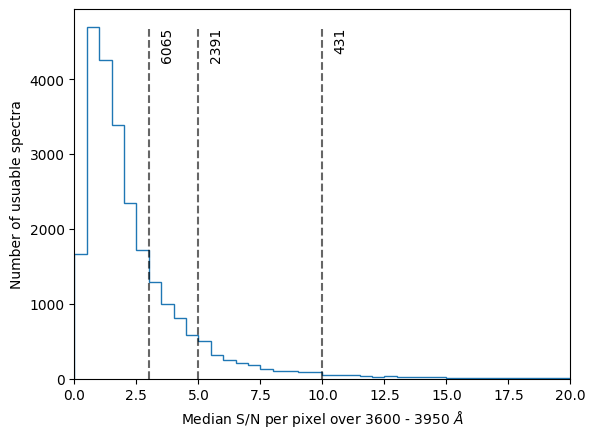

In [134]:
h, e = np.histogram(snrs_cat, bins=50, range=(0, 25))
plt.stairs(h, e)

plt.vlines(lines, 0, max(h), linestyles="--", alpha=0.6, color="black")
for i in range(len(lines)):
    plt.text(lines[i] + 1, max(h), f"{num_specs_above_line[i]:.0f}", rotation=90, ha="right", va="top")

plt.xlim([0, 20])
plt.xlabel(r"Median S/N per pixel over 3600 - 3950 $\AA$")
plt.ylabel("Number of usuable spectra")
plt.savefig("plots/signal_to_noise_distribution.pdf", format="PDF")
plt.show()